# Unsupervised methods in NLP - Assignment 3

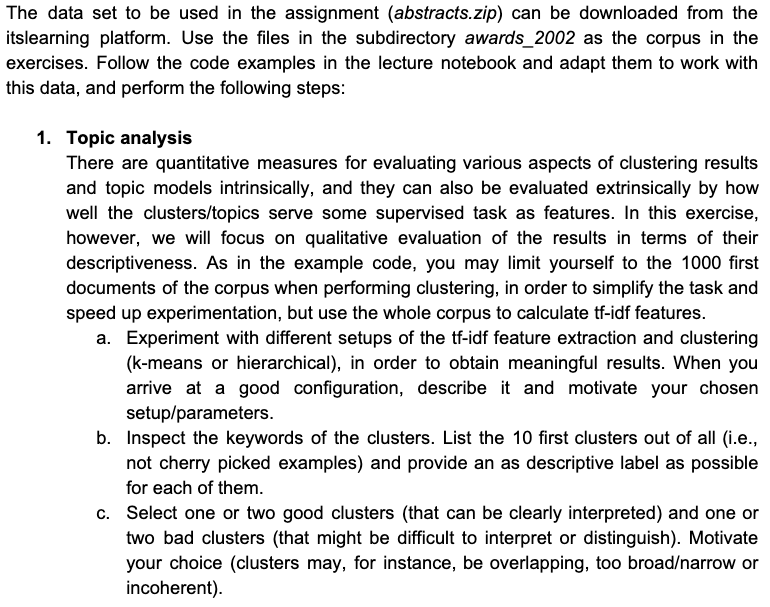
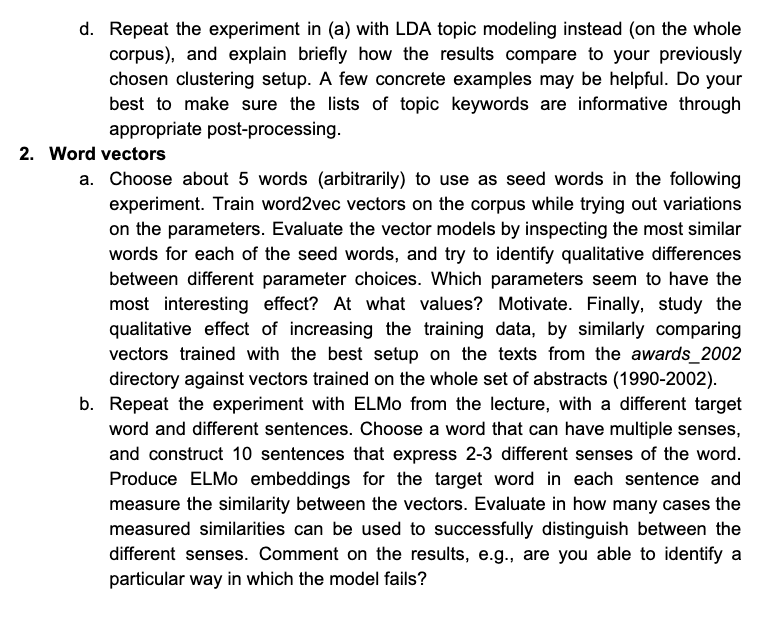

In [1]:
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import os
from collections import Counter
import heapq, numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models
import gensim
import tensorflow_hub as hub
import tensorflow as tf

## 1 Topic Analysis

In [5]:
list_of_paths = []

def list_files(dir):
    for root, dirs, files in os.walk(dir):
        for name in files:
            if '.txt' in name:
                list_of_paths.append(os.path.join(root, name))
    

entries = os.listdir('abstracts1/')
#print(entries)
for entry in entries:
    file_path = 'abstracts1/' + entry
    list_files(file_path)
    
print(list_of_paths[1000])
print(len(list_of_paths))

abstracts1/awards_2002/awd_2002_37/a0237472.txt
9923


In [96]:
documents = []

for path in list_of_paths:
    with open(path, "rt", encoding="latin-1") as f:
        text = f.read()
        text = text.replace("\n", " ")
        text = text.replace("\t", " ")
        documents.append(text = re.sub(' +', ' ', text))

In [97]:
# Set parameters and initialize
tfidf_vectorizer = TfidfVectorizer(min_df=2, use_idf=True, sublinear_tf=True, max_df=0.95, max_features=60000)
# Tip: the vectorizer also supports extracting n-gram features (common short sequences of words), which may be more descriptive but also much less frequent

# Calcualate term-document matrix with tf-idf scores
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Check matrix shape
tfidf_matrix.toarray().shape # N_docs x N_terms

(10, 49)

In [98]:
documents[2]

' This is a joint project of the New Jersey Institute of Technology as lead institution for the North/Central New Jersey and Camden County College as lead institution for the Southern New Jersey CIM Consortia. The consortia operate fully articulated programs aimed at the AAS and BSET degrees in Manufacturing Engineering Technology. The consortia consists of 13 community colleges and NJIT in the North/Central; Camden County College, 5 other community colleges and NJIT in the Southern. Articulated curricula of the two consortia include a two course sequence in Manufacturing Systems. This sequence is critical to the success of the program. Significant deviations in course content and emphasis among the member colleges have been noted. This project will solicit input from the manufacturing industry on required skills which should be attained through the first course of the two-course sequence. During a summer Curriculum Development Institute, selected faculty members will develop model cur

In [4]:
# Inspect terms in vocabulary
print(tfidf_vectorizer.get_feature_names()[:10])
print(tfidf_vectorizer.get_feature_names()[-10:])

['00', '000', '0000', '0000099', '0000912', '0001', '000l', '001', '0017', '002']
['zumberge', 'zuni', 'zuo', 'zurich', 'zutic', 'zworski', 'zygmund', 'zygomycetes', 'zygomycota', 'zygotic']


In [5]:
# Inspect document frequencies (counts) of terms
terms_in_docs = tfidf_vectorizer.inverse_transform(tfidf_matrix)
token_counter = Counter()
for terms in terms_in_docs:
    token_counter.update(terms)

for term, count in token_counter.most_common(28):
    print("%d\t%s" % (count, term))

9402	grant
8743	this
8270	is
8229	will
8070	2002
7929	edu
7708	research
7641	be
7539	on
7311	with
7167	that
6657	direct
6657	are
6603	by
6489	31
6442	as
6094	standard
6010	from
5825	an
5447	project
5442	at
5403	these
5396	university
5198	other
5181	division
4843	2003
4607	applications
4607	sciences


In [6]:
## Inspect top terms per document
features = tfidf_vectorizer.get_feature_names()
for doc_i in range(5):
    print("\nDocument %d, top terms by TF-IDF" % doc_i)
    for term, score in sorted(list(zip(features,tfidf_matrix.toarray()[doc_i])), key=lambda x:-x[1])[:5]:
        print("%.2f\t%s" % (score, term))


Document 0, top terms by TF-IDF
0.30	trafficking
0.19	database
0.19	drug
0.17	protein
0.16	discovery

Document 1, top terms by TF-IDF
0.27	hayes
0.20	nmr
0.18	heterostructures
0.18	optically
0.14	wuchem

Document 2, top terms by TF-IDF
0.23	fabric
0.19	textiles
0.16	pesticides
0.16	weapons
0.16	drapes

Document 3, top terms by TF-IDF
0.19	lightning
0.18	snow
0.15	forecasting
0.15	synoptic
0.15	dangerous

Document 4, top terms by TF-IDF
0.18	dots
0.18	tutorials
0.17	helium
0.17	shumway
0.16	path


In [7]:
# Alternatively: Inspect IDF values directly
print(sorted(zip(features,tfidf_vectorizer._tfidf.idf_),key=lambda x:x[1])[:20])

[('grant', 1.0539272785346148), ('this', 1.126588314955317), ('is', 1.182200645119785), ('will', 1.187170051140576), ('2002', 1.2066786754873193), ('edu', 1.224303030182798), ('research', 1.2525675883524294), ('be', 1.2612967168048463), ('on', 1.2747338838096898), ('with', 1.3054392316777057), ('that', 1.3253293901569252), ('are', 1.3991369266767215), ('direct', 1.3991369266767215), ('by', 1.407280539771673), ('31', 1.424693535113556), ('as', 1.431961795673049), ('standard', 1.4874873028963198), ('from', 1.5013649417725294), ('an', 1.5326254072923118), ('project', 1.5997074969823433)]


In [8]:
print(tfidf_matrix.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.03130059 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.03434402 ... 0.         0.         0.        ]
 [0.         0.         0.02183165 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [9]:
print("Document vector length:", tfidf_matrix.shape[1])
for i in range(5):
    print("Non-zero dimensions for document %d: %d" % (i, len([x for x in tfidf_matrix.toarray()[i] if x > 0])))

Document vector length: 35259
Non-zero dimensions for document 0: 127
Non-zero dimensions for document 1: 151
Non-zero dimensions for document 2: 202
Non-zero dimensions for document 3: 226
Non-zero dimensions for document 4: 209


In [10]:
# Does not work, always prints same number of documents regardless of feature.
print("Sample word:", features[4000])
print("Occurs in %d documents" % len([x for x in tfidf_matrix.toarray()[:][4000] if x > 0]))
print("out of %d documents" % len(tfidf_matrix.toarray()))

Sample word: adjustments
Occurs in 280 documents
out of 9923 documents


In [11]:
matrix_sample = tfidf_matrix[:1000]

In [12]:
# Do clustering
km = KMeans(n_clusters=40, random_state=123, verbose=0)
km.fit(matrix_sample)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=40, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [13]:
# Custom function to print top keywords for each cluster
def print_clusters(matrix, clusters, n_keywords=10):
    for cluster in range(min(clusters), max(clusters)+1):
        cluster_docs = [i for i, c in enumerate(clusters) if c == cluster]
        print("Cluster: %d (%d docs)" % (cluster, len(cluster_docs)))
        
        # Keep scores for top n terms
        new_matrix = np.zeros((len(cluster_docs), matrix.shape[1]))
        for cluster_i, doc_vec in enumerate(matrix[cluster_docs].toarray()):
            for idx, score in heapq.nlargest(n_keywords, enumerate(doc_vec), key=lambda x:x[1]):
                new_matrix[cluster_i][idx] = score

        # Aggregate scores for kept top terms
        keywords = heapq.nlargest(n_keywords, zip(new_matrix.sum(axis=0), features))
        print(', '.join([w for s,w in keywords]))
        print()
        
print_clusters(matrix_sample, km.labels_)

Cluster: 0 (5 docs)
laurentia, outboard, successions, sedimentary, petrologic, inboard, mesoproterozoic, rodinia, geochronology, provenance

Cluster: 1 (15 docs)
pollinator, genetic, inbreeding, fragmentation, variation, fragments, mhc, coat, maasai, tropical

Cluster: 2 (19 docs)
hydrologic, fracture, npp, inter, invasibility, variability, champaign, climate, unstructured, vegetation

Cluster: 3 (17 docs)
solar, weather, storm, wind, hurricane, vapor, assimilation, interdomain, forecasting, boulder

Cluster: 4 (43 docs)
nanoparticles, chemistry, compounds, excited, complexes, dissociation, professor, organic, wilson, 1962

Cluster: 5 (28 docs)
wireless, coding, dipole, codes, plasmas, multiuser, fading, channel, phy, curves

Cluster: 6 (25 docs)
ast, stars, stellar, pulsars, planets, star, binary, extrasolar, disk, galactic

Cluster: 7 (12 docs)
nonlinear, equations, controllers, piezoceramics, monge, piezoceramic, graded, acoustic, combustion, ampere

Cluster: 8 (8 docs)
sciencentral

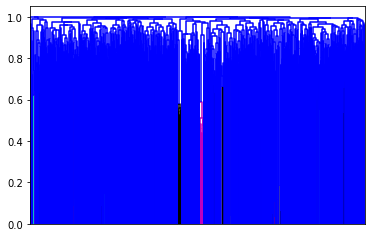

In [14]:
### Hierarchical clustering (alternative approach)
Z = linkage(matrix_sample.todense(), metric='cosine', method='complete')
_ = dendrogram(Z, no_labels=True) # Plot dendrogram chart

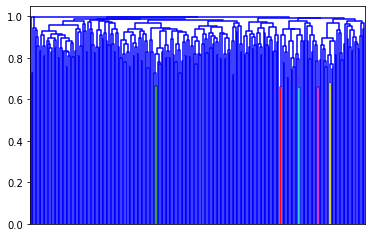

In [15]:
# View dendrogram for subset
Z_ = linkage(matrix_sample.todense()[:250], metric='cosine', method='complete')
_ = dendrogram(Z_, no_labels=True) # Plot dentrogram chart

In [16]:
## Get flat clusters from cluster hierarchy

clusters = fcluster(Z, 40, criterion='maxclust') # Create fix number of flat clusters
#clusters = fcluster(Z, 0.99, criterion='distance') # Create flat clusters by distance threshold

print_clusters(matrix_sample, clusters)

Cluster: 1 (3 docs)
dis, interagency, bozzelli, booz, florence, 22102, 20240, 22041, 5107, supprt

Cluster: 2 (12 docs)
ship, operations, goad, 5411, oce, oceanographic, mcduff, instrumentation, ships, nearshore

Cluster: 3 (28 docs)
weather, auroral, wind, magnetosphere, solar, storms, ring, ionosphere, ionospheric, alfven

Cluster: 4 (14 docs)
solar, clouds, photospheric, miami, aerosol, coronal, cloud, radiative, helioseismic, cirrus

Cluster: 5 (32 docs)
iis, metasearch, subjectivity, engine, search, engines, ie, classifier, retrieval, webscales

Cluster: 6 (63 docs)
embedded, hybrid, security, trusted, execution, qos, workshop, pl, protocol, predictors

Cluster: 7 (32 docs)
ii, cad, reagents, fuel, fetal, chitin, customer, artwork, product, coding

Cluster: 8 (54 docs)
frp, seismic, straightening, mitigation, purdue, repair, wind, liquefaction, control, resistivity

Cluster: 9 (35 docs)
bes, arsenic, cardiac, iron, assistive, inactivation, disabilities, haiwee, muscle, berkeley

C

## a) 
#### tf-idf feature extraction:
I felt I got the best features extracted with the following settings(min_df=2, use_idf=True, sublinear_tf=True, max_df=0.95, max_features=60000). We spent most time tuning the min_df and max_df parameters. In the end I chose to go with min_df=2 to exclude some obscure terms, abbreviations, figures that appeared only once in the corpus. These terms, abbreviations, figures might have had some meaning for someone familiar with a specific industry or field but to us they meant nothing and added no value so we chose to exclude them. In regards to max_df parameter we chose to use the value 0.95 which results in the exclusion of features that appear in more than 95% of the documents. This allowed us to easily exclude words that were part of the document format but provided no value to our anaylsis as they appeared in every single document. We also tried a few different values for the ngram_range parameter but did not find it improved the results of the clustering. 
#### clusteting (k-means or hierarchical):
Above, we have used both k-means and hierarchical clustering to try and obtain meaningful results. We found it is more informational and valuable from an analytical perspective to have more clusters, which allows for fewer documents per cluster. We arbitrarily picked 40 for both clustering methods as we found 40 was better than 30 and 50 after a few tests. By quickly reviewing the clusters produced by the k-means(n_clusters=40, random_state=123, verbose=0) and the hierarchical(Z, 40, criterion='maxclust') methods we're unable to draw a clear conclusion as to which produces better results. Both produce varying results, some clusters seem to make sense and some not. Since we are not data scientist and have no way of identifying the better clustering method, we'll go with our gut and choose to focus on the clusters produced by k-means for tasks 1b and 1c. 

---

## b)
#### cluster labeling (k-means):
##### Cluster: 0 (5 docs)
laurentia, outboard, successions, sedimentary, petrologic, inboard, mesoproterozoic, rodinia, geochronology, provenance

label: physics/motors

##### Cluster: 1 (15 docs)
pollinator, genetic, inbreeding, fragmentation, variation, fragments, mhc, coat, maasai, tropical

label: forestry

##### Cluster: 2 (19 docs)
hydrologic, fracture, npp, inter, invasibility, variability, champaign, climate, unstructured, vegetation

label: climate/waterway

##### Cluster: 3 (17 docs)

solar, weather, storm, wind, hurricane, vapor, assimilation, interdomain, forecasting, boulder

label: meteorology/storms/Hurricanes

##### Cluster: 4 (43 docs) 
nanoparticles, chemistry, compounds, excited, complexes, dissociation, professor, organic, wilson, 1962

label: chemistry

##### Cluster: 5 (28 docs)
wireless, coding, dipole, codes, plasmas, multiuser, fading, channel, phy, curves

label: physics/chemistry

##### Cluster: 6 (25 docs)
ast, stars, stellar, pulsars, planets, star, binary, extrasolar, disk, galactic

label: planetary science / astronomy

##### Cluster: 7 (12 docs)
nonlinear, equations, controllers, piezoceramics, monge, piezoceramic, graded, acoustic, combustion, ampere

label: physics

##### Cluster: 8 (8 docs)
sciencentral, esi, children, professor, nova, frontier, footage, collider, stories, pbs

label: phyiscs

##### Cluster: 9 (10 docs)
ship, operations, goad, 5411, oce, mcduff, oceanographic, reimbursable, corliss, ocean

label: marine biology

---


## c)

#### Select two good and two bad clusters:

##### Good
Cluster: 3 (17 docs)
solar, weather, storm, wind, hurricane, vapor, assimilation, interdomain, forecasting, boulder

Cluster: 6 (25 docs)
ast, stars, stellar, pulsars, planets, star, binary, extrasolar, disk, galactic

motivation: We think cluster 3 is clearly about meteorology/storms/hurricanes. Having the word hurricane showing up as a feature does help, and therefore we think it is a good cluster. Cluster 6 is about planetary science/astronomy, which seems clear because of the many space related features. 

##### Bad

Cluster: 15 (14 docs)
dge, none, fellowships, fellowship, graduate, 7172, 32000, 67500, sheppard, stony

Cluster: 20 (22 docs)
embedded, hybrid, pl, predictors, verification, qos, gupta, piecewise, garbage, handheld

motivation: We picked cluster 15 and 20 as examples of bad clusters. Cluster 15 contains a lot of features(dge, none, and the numbers) that provide very little information to someone not familiar with the text. Cluster 20 to me seems a bit incoherent. I could not make any educated guess as to what this cluster might be about. 

---


In [17]:
# Fast and simple tokenization
new_vectorizer = TfidfVectorizer()
word_tokenizer = new_vectorizer.build_tokenizer()
tokenized_text = [word_tokenizer(doc.lower()) for doc in documents]

# Train LDA model
dictionary = corpora.Dictionary(tokenized_text)
lda_corpus = [dictionary.doc2bow(text) for text in tokenized_text]
lda_model = models.LdaModel(lda_corpus, id2word=dictionary, num_topics=40)

In [18]:
# Inspect topics
for i, topic in lda_model.show_topics(num_words=10, num_topics=40, formatted=False):
    print("Topic", i)
    for term, score in topic:
        print("%.4f\t%s" % (score,term))
    print()

Topic 0
0.0656	the
0.0407	of
0.0379	and
0.0191	in
0.0178	to
0.0130	will
0.0122	for
0.0095	award
0.0080	this
0.0070	program

Topic 1
0.0382	of
0.0373	the
0.0247	and
0.0191	award
0.0158	in
0.0130	int
0.0121	university
0.0112	program
0.0110	to
0.0108	for

Topic 2
0.0207	the
0.0189	of
0.0166	and
0.0135	to
0.0125	in
0.0079	dri
0.0055	will
0.0051	for
0.0051	desert
0.0047	an

Topic 3
0.0342	the
0.0248	and
0.0198	materials
0.0154	optical
0.0151	of
0.0138	will
0.0129	in
0.0129	high
0.0116	for
0.0108	to

Topic 4
0.0366	award
0.0296	program
0.0284	investigator
0.0254	nsf
0.0239	date
0.0234	estimated
0.0223	2002
0.0168	principal
0.0161	current
0.0156	of

Topic 5
0.0089	of
0.0080	the
0.0060	and
0.0045	in
0.0038	to
0.0023	is
0.0018	for
0.0017	award
0.0014	will
0.0012	investigator

Topic 6
0.0046	the
0.0032	and
0.0030	in
0.0023	of
0.0021	33124
0.0020	2210
0.0020	284
0.0019	gables
0.0019	to
0.0014	investigator

Topic 7
0.0420	and
0.0347	teachers
0.0267	mathematics
0.0249	the
0.0194	of
0.0175	in
0.0150

In [19]:
filtered_words = "research project new it such has their these have estimated principal which this that will current amt the of and to for in or is be may an a with at are on by as from can title type nsf org latest amendment date file award number award instr prgm manager start date expires expected total investigator sponsor nsf program fld applictn program ref abstract"

# Inspect topics
for i, topic in lda_model.show_topics(num_words=100, num_topics=40, formatted=False):
    print("Topic", i)
    printed_terms = 0
    for term, score in topic:
        if printed_terms >= 10:
            break
        elif term in filtered_words.split():
            continue
        printed_terms += 1
        print("%.4f\t%s" % (score,term))
    print()

Topic 0
0.0045	2002
0.0036	data
0.0032	grant
0.0025	sciences
0.0025	university
0.0024	study
0.0024	2003
0.0024	co
0.0023	social
0.0021	economic

Topic 1
0.0130	int
0.0121	university
0.0090	office
0.0084	us
0.0082	dr
0.0069	2002
0.0069	2003
0.0064	internatl
0.0062	workshop
0.0057	engineering

Topic 2
0.0079	dri
0.0051	desert
0.0044	nevada
0.0036	ins
0.0036	ice
0.0030	aux
0.0025	673
0.0025	reno
0.0025	florence
0.0023	2002

Topic 3
0.0198	materials
0.0154	optical
0.0129	high
0.0087	devices
0.0085	thermal
0.0074	fabrication
0.0072	low
0.0071	temperature
0.0070	film
0.0066	phase

Topic 4
0.0223	2002
0.0098	education
0.0090	division
0.0078	31
0.0074	applications
0.0072	september
0.0072	nec
0.0072	0000099
0.0070	2003
0.0068	other

Topic 5
0.0005	2002
0.0005	edu
0.0005	university
0.0005	grant
0.0005	2003
0.0005	other
0.0004	materials
0.0004	applications
0.0004	division
0.0004	high

Topic 6
0.0021	33124
0.0020	2210
0.0020	284
0.0019	gables
0.0008	coral
0.0008	students
0.0007	income
0.0006	305
0

## d) 
#### Comparing LDA topic modeling to clustering (k-means & hierarchical)

We decided to use 40 topic categories to match the amount of clusters we chose during k-means and hierarchical clustering above. Then in the post-processing phase we had to remove stop words and a dozen or so other words because they were uninformative, for example, research, new, it, such, estimated etc. We noticed a few differences in the results produced by the LDA topic modeling when comparing to the previous clustering method results. First, the features that are brought forth are very different. We quickly searched the word features in the first topic(0) among the 40 clusters produced by the k-means method and we were able to find very few matches. Words like technology, system, design, egineering, all exist in the topic 0, however, none of the words are found in any of the 40 k-means clusters. Second, the topics share a lot words, for instance design, egineering, and techonlogy appear in many different topics. These words are informative in our opinion, however, when we compare to the results of the k-means clustering we feel that the features brought forth by the clustering method were more informative on this corpus. 

---

## 2. Word Vectors

In [20]:
features = tfidf_vectorizer.get_feature_names()

print("Similar terms to:", features[4500])
# Get most similar terms according to the cosine similarity of their vectors (columns in the term-document matrix)
heapq.nlargest(10, zip(cosine_similarity(tfidf_matrix[:,4500].todense().T, tfidf_matrix.todense().T)[0], features))

Similar terms to: alox


[(0.9999999999999998, 'alox'),
 (0.6119272215502982, 'moir'),
 (0.5359985838829192, 'chirped'),
 (0.5284058353811316, 'buffers'),
 (0.5173751824672509, 'abs'),
 (0.48807029365717386, 'andreev'),
 (0.4364605142589163, 'ketterson'),
 (0.42323350780693725, 'chuang'),
 (0.3646085577768899, 'gratings'),
 (0.3409287230170156, 'nb')]

In [21]:
# size (int, optional) – Dimensionality of the word vectors.

# window (int, optional) – Maximum distance between the current and predicted word within a sentence.

# min_count (int, optional) – Ignores all words with total frequency lower than this.

# sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.

# hs ({0, 1}, optional) – If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.

# workers (int, optional) – Use these many worker threads to train the model (=faster training with multicore machines).

#iter (int, optional) – Number of iterations (epochs) over the corpus.

Run 1:

In [22]:
# Train word2vec model
vectors = gensim.models.Word2Vec(tokenized_text, size=100, window=5, min_count=5, workers=4)
print(vectors)
print()
# Inspect words with vectors most similar to a given word
print("Most similar to:", 'nature')
print(vectors.wv.most_similar('nature'))
print()
print("Most similar to:", 'car')
print(vectors.wv.most_similar('car'))
print()
print("Most similar to:", 'house')
print(vectors.wv.most_similar('house'))
print()
print("Most similar to:", 'lamp')
print(vectors.wv.most_similar('lamp'))
print()
print("Most similar to:", 'running')
print(vectors.wv.most_similar('running'))
print()

Word2Vec(vocab=23199, size=100, alpha=0.025)

Most similar to: nature
[('importance', 0.7421190738677979), ('origins', 0.6768912076950073), ('possibility', 0.6578589677810669), ('limits', 0.6545846462249756), ('role', 0.6465768814086914), ('origin', 0.6465039253234863), ('fundamental', 0.6403632760047913), ('behavior', 0.6383086442947388), ('existence', 0.6348341703414917), ('significance', 0.6326483488082886)]

Most similar to: car
[('categorical', 0.7649891376495361), ('finer', 0.7621810436248779), ('signs', 0.7578113079071045), ('slightly', 0.747144341468811), ('factorization', 0.7468963861465454), ('criticality', 0.742644190788269), ('mir1', 0.7410473823547363), ('fluorophores', 0.7341606616973877), ('folded', 0.7339901328086853), ('alternatively', 0.7319687008857727)]

Most similar to: house
[('lectures', 0.6388707160949707), ('talks', 0.6314864158630371), ('1994', 0.621314525604248), ('1981', 0.6191537380218506), ('books', 0.6152849197387695), ('served', 0.6145111322402954), ('pa

Run 2:

In [23]:
vectors = gensim.models.Word2Vec(tokenized_text, size=300, window=10, min_count=2, workers=4)
print(vectors)
print()
print("Most similar to:", 'nature')
print(vectors.wv.most_similar('nature'))
print()
print("Most similar to:", 'car')
print(vectors.wv.most_similar('car'))
print()
print("Most similar to:", 'house')
print(vectors.wv.most_similar('house'))
print()
print("Most similar to:", 'lamp')
print(vectors.wv.most_similar('lamp'))
print()
print("Most similar to:", 'running')
print(vectors.wv.most_similar('running'))
print()

Word2Vec(vocab=45278, size=300, alpha=0.025)

Most similar to: nature
[('importance', 0.7320252060890198), ('behavior', 0.7061607837677002), ('forces', 0.6952733993530273), ('significance', 0.685638964176178), ('possibility', 0.6731745600700378), ('origins', 0.6671448945999146), ('property', 0.6670918464660645), ('consequences', 0.6560214757919312), ('underlying', 0.653191328048706), ('role', 0.6479761600494385)]

Most similar to: car
[('weigh', 0.7464094161987305), ('sell', 0.7400470972061157), ('prone', 0.7351747751235962), ('lineup', 0.7343724370002747), ('sometimes', 0.7325977087020874), ('merely', 0.7307898998260498), ('optimally', 0.730697751045227), ('exponentially', 0.7283294200897217), ('elliptical', 0.7268581390380859), ('overly', 0.7241524457931519)]

Most similar to: house
[('piloted', 0.6673429012298584), ('invitations', 0.6583204865455627), ('speaker', 0.6505431532859802), ('bimonthly', 0.6362015008926392), ('delivered', 0.6262569427490234), ('125', 0.6237165331840515), (

Run 3:

In [24]:
vectors = gensim.models.Word2Vec(tokenized_text, size=300, window=10, min_count=2, workers=4, iter=5)
print(vectors)
print()
print("Most similar to:", 'nature')
print(vectors.wv.most_similar('nature'))
print()
print("Most similar to:", 'car')
print(vectors.wv.most_similar('car'))
print()
print("Most similar to:", 'house')
print(vectors.wv.most_similar('house'))
print()
print("Most similar to:", 'lamp')
print(vectors.wv.most_similar('lamp'))
print()
print("Most similar to:", 'running')
print(vectors.wv.most_similar('running'))
print()

Word2Vec(vocab=45278, size=300, alpha=0.025)

Most similar to: nature
[('importance', 0.7492261528968811), ('significance', 0.6879353523254395), ('behavior', 0.6786998510360718), ('origins', 0.677944540977478), ('role', 0.6712415218353271), ('consequences', 0.669415295124054), ('planet', 0.6634981632232666), ('phenomenon', 0.6630656719207764), ('property', 0.6613156795501709), ('existence', 0.6484744548797607)]

Most similar to: car
[('tends', 0.763765811920166), ('persistent', 0.753199577331543), ('impatiently', 0.7523443698883057), ('null', 0.7478687763214111), ('die', 0.7388452291488647), ('categorical', 0.7382844686508179), ('decoder', 0.7379791736602783), ('sometimes', 0.7325997948646545), ('fairly', 0.7315847277641296), ('completely', 0.7300766110420227)]

Most similar to: house
[('pages', 0.6610521078109741), ('48', 0.6489169001579285), ('companion', 0.6434097290039062), ('visitors', 0.6419861316680908), ('creol', 0.6355440616607666), ('laboratories', 0.6339720487594604), ('coll

Run 4:

In [25]:
vectors = gensim.models.Word2Vec(tokenized_text, size=100, window=5, min_count=5, workers=4, sg=1)
print(vectors)
print()
print("Most similar to:", 'nature')
print(vectors.wv.most_similar('nature'))
print()
print("Most similar to:", 'car')
print(vectors.wv.most_similar('car'))
print()
print("Most similar to:", 'house')
print(vectors.wv.most_similar('house'))
print()
print("Most similar to:", 'lamp')
print(vectors.wv.most_similar('lamp'))
print()
print("Most similar to:", 'running')
print(vectors.wv.most_similar('running'))
print()

Word2Vec(vocab=23199, size=100, alpha=0.025)

Most similar to: nature
[('deeply', 0.6939239501953125), ('intricate', 0.6836076974868774), ('peculiar', 0.6736513376235962), ('acoustical', 0.6689180135726929), ('interplay', 0.6654185652732849), ('firstly', 0.6616603136062622), ('clarification', 0.658038854598999), ('intimate', 0.6579605937004089), ('elusive', 0.6576391458511353), ('behaviour', 0.6567254662513733)]

Most similar to: car
[('tickets', 0.8150953054428101), ('oblivious', 0.8122934103012085), ('auditing', 0.8106976747512817), ('bugs', 0.8077422380447388), ('notice', 0.8029335737228394), ('computes', 0.7997748851776123), ('pulled', 0.798437774181366), ('corrective', 0.7983034253120422), ('button', 0.7952399253845215), ('bypass', 0.7947444915771484)]

Most similar to: house
[('ard', 0.7140220403671265), ('kit', 0.7042441368103027), ('vaults', 0.7039498090744019), ('herbarium', 0.6962267160415649), ('argonne', 0.6917704343795776), ('desk', 0.6863361597061157), ('briefings', 0.685

Run 5:

In [33]:
vectors = gensim.models.Word2Vec(tokenized_text, size=300, window=10, min_count=2, workers=4, sg=1, iter=5)
print(vectors)
print("Most similar to:", 'nature')
print(vectors.wv.most_similar('nature'))
print()
print("Most similar to:", 'car')
print(vectors.wv.most_similar('car'))
print()
print("Most similar to:", 'house')
print(vectors.wv.most_similar('house'))
print()
print("Most similar to:", 'lamp')
print(vectors.wv.most_similar('lamp'))
print()
print("Most similar to:", 'running')
print(vectors.wv.most_similar('running'))
print()

Word2Vec(vocab=45278, size=300, alpha=0.025)
Most similar to: nature
[('puzzles', 0.5752205848693848), ('underpinning', 0.5749119520187378), ('underlies', 0.5720927715301514), ('firstly', 0.5685632824897766), ('imperfectly', 0.5668221712112427), ('astonishing', 0.5658304691314697), ('underpinnings', 0.5632932186126709), ('microeconomic', 0.5619580745697021), ('inadequacy', 0.5590473413467407), ('furthers', 0.5590397119522095)]

Most similar to: car
[('crash', 0.7714900970458984), ('chewing', 0.7621539235115051), ('cardiopulmonary', 0.759753406047821), ('unhedgable', 0.7541892528533936), ('televisions', 0.7520827054977417), ('ircs', 0.7493164539337158), ('decides', 0.7468448877334595), ('adversary', 0.7464061975479126), ('simplistic', 0.7457714080810547), ('perpetrator', 0.745314359664917)]

Most similar to: house
[('houses', 0.6073800325393677), ('developer', 0.5953941345214844), ('renovated', 0.594376802444458), ('article', 0.5863790512084961), ('manuscripts', 0.583586573600769), ('ap

## a) 
#### Evaluate vector models and try to idenfity qualitative differences between the parameter choices
On the first three vector models I played around with three parameters, size, window, and min_count. On the first run I used size=100, window=5, min_count=5 and on the second run size=300, window=10, min_count=2. When comparing the results of the two runs we see that they share some of the words while some are new different, so quite similar. Then when we look at the third run where I used paramters size=300, window=10, min_count=2, and iter=5 we can see that the results differ even more from the first run. 

On the forth run I used parameters size=100, window=5, min_count=5, and sg=1 and the results changed quite a lot. 80-90% of the words changed from the previous three runs. Then on run five is used parameters size=300, window=10, min_count=2, sg=1, and iter=5 and I results changed a little bit compared to run four.

In conclusion, I saw the biggest differences in results when I added the sg parameter, however, I would not call any of the results very good and this is probably because the corpus is too small and therefore vectors too sparse. I'm not sure what else I can say here. 

Next I'll trian a new word2vec model on a bigger corpus.

---

In [4]:
list_of_paths = []

def list_files(dir):
    for root, dirs, files in os.walk(dir):
        for name in files:
            if '.txt' in name:
                list_of_paths.append(os.path.join(root, name))

entries = os.listdir('abstracts/')
print(entries)
for entry in entries:
    file_path = 'abstracts/' + entry
    list_files(file_path)

['awards_1992', 'awards_1995', 'awards_1994', 'awards_1993', 'awards_2000', 'awards_2001', 'awards_1996', 'awards_1991', 'awards_1998', 'awards_1999', 'awards_1990', 'awards_1997', 'awards_2003', 'awards_2002']


In [5]:
print(list_of_paths[1000])
print(len(list_of_paths))

abstracts/awards_1992/awd_1992_09/a9209652.txt
134159


In [7]:
all_documents = []

for path in list_of_paths:
    with open(path, "rt", encoding="latin-1") as f:
        text = f.read()
        text = text.replace("\n", " ")
        text = text.replace("\t", " ")
        text = re.sub(' +', ' ', text)
        all_documents.append(re.sub(r'.*Abstract :', '', text))

In [8]:
# Set parameters and initialize
tfidf_vectorizer = TfidfVectorizer(min_df=2, use_idf=True, sublinear_tf=True,max_df=0.95, max_features=60000)
# Tip: the vectorizer also supports extracting n-gram features (common short sequences of words), which may be more descriptive but also much less frequent

# Calcualate term-document matrix with tf-idf scores
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)

# Check matrix shape
tfidf_matrix.toarray().shape # N_docs x N_terms

(134159, 60000)

In [9]:
all_documents[2]

' This is a joint project of the New Jersey Institute of Technology as lead institution for the North/Central New Jersey and Camden County College as lead institution for the Southern New Jersey CIM Consortia. The consortia operate fully articulated programs aimed at the AAS and BSET degrees in Manufacturing Engineering Technology. The consortia consists of 13 community colleges and NJIT in the North/Central; Camden County College, 5 other community colleges and NJIT in the Southern. Articulated curricula of the two consortia include a two course sequence in Manufacturing Systems. This sequence is critical to the success of the program. Significant deviations in course content and emphasis among the member colleges have been noted. This project will solicit input from the manufacturing industry on required skills which should be attained through the first course of the two-course sequence. During a summer Curriculum Development Institute, selected faculty members will develop model cur

In [10]:
# Fast and simple tokenization
new_vectorizer = TfidfVectorizer()
word_tokenizer = new_vectorizer.build_tokenizer()
tokenized_text = [word_tokenizer(doc.lower()) for doc in all_documents]

In [11]:
# Train LDA model
dictionary = corpora.Dictionary(tokenized_text)
lda_corpus = [dictionary.doc2bow(text) for text in tokenized_text]
lda_model = models.LdaModel(lda_corpus, id2word=dictionary, num_topics=40)

In [12]:
filtered_words = "research project new it such has their these have estimated principal which this that will current amt the of and to for in or is be may an a with at are on by as from can title type nsf org latest amendment date file award number award instr prgm manager start date expires expected total investigator sponsor nsf program fld applictn program ref abstract"

# Inspect topics
for i, topic in lda_model.show_topics(num_words=100, num_topics=40, formatted=False):
    print("Topic", i)
    printed_terms = 0
    for term, score in topic:
        if printed_terms >= 10:
            break
        elif term in filtered_words.split():
            continue
        printed_terms += 1
        print("%.4f\t%s" % (score,term))
    print()

Topic 0
0.0507	civil
0.0499	concrete
0.0411	girls
0.0333	hydrothermal
0.0298	geotechnical
0.0277	2d
0.0245	mit
0.0222	exhibit
0.0203	bridge
0.0191	buildings

Topic 1
0.0487	devices
0.0328	optical
0.0258	quantum
0.0244	device
0.0224	electronic
0.0210	materials
0.0197	high
0.0192	semiconductor
0.0174	magnetic
0.0152	electrical

Topic 2
0.0058	study
0.0056	model
0.0050	models
0.0048	wave
0.0042	field
0.0039	waves
0.0038	results
0.0037	scale
0.0036	between
0.0036	understanding

Topic 3
0.0222	language
0.0114	visual
0.0097	learning
0.0096	object
0.0095	objects
0.0089	languages
0.0079	database
0.0075	information
0.0074	programming
0.0069	we

Topic 4
0.0146	university
0.0124	equipment
0.0107	instrumentation
0.0089	instrument
0.0079	laboratory
0.0076	used
0.0076	facility
0.0072	chemistry
0.0071	state
0.0065	support

Topic 5
0.0404	students
0.0174	graduate
0.0137	undergraduate
0.0114	engineering
0.0094	faculty
0.0088	training
0.0081	education
0.0076	university
0.0075	science
0.0065	student

Top

In [13]:
#features = tfidf_vectorizer.get_feature_names()

#print("Similar terms to:", features[4500])
# Get most similar terms according to the cosine similarity of their vectors (columns in the term-document matrix)
#heapq.nlargest(10, zip(cosine_similarity(tfidf_matrix[:,4500].todense().T, tfidf_matrix.todense().T)[0], features))

Run 6:

In [14]:
# Train word2vec model
vectors = gensim.models.Word2Vec(tokenized_text, size=100, window=5, min_count=5, workers=4)
print(vectors)
print()
# Inspect words with vectors most similar to a given word
print("Most similar to:", 'nature')
print(vectors.wv.most_similar('nature'))
print()
print("Most similar to:", 'car')
print(vectors.wv.most_similar('car'))
print()
print("Most similar to:", 'house')
print(vectors.wv.most_similar('house'))
print()
print("Most similar to:", 'lamp')
print(vectors.wv.most_similar('lamp'))
print()
print("Most similar to:", 'running')
print(vectors.wv.most_similar('running'))
print()

Word2Vec(vocab=60134, size=100, alpha=0.025)

Most similar to: nature
[('origins', 0.6345757842063904), ('behavior', 0.6086331605911255), ('character', 0.5950214862823486), ('origin', 0.5699654817581177), ('details', 0.5595619082450867), ('phenomenon', 0.5563981533050537), ('evolution', 0.5375258922576904), ('role', 0.5295149087905884), ('manifestation', 0.5272961258888245), ('consequences', 0.5251209735870361)]

Most similar to: car
[('cars', 0.725395917892456), ('trucks', 0.7007901072502136), ('automobiles', 0.6293994188308716), ('automobile', 0.6276869773864746), ('passenger', 0.6257535219192505), ('airline', 0.6133261322975159), ('wheel', 0.6069292426109314), ('truck', 0.6065547466278076), ('refrigerators', 0.5943032503128052), ('mill', 0.5913124680519104)]

Most similar to: house
[('houses', 0.6326617002487183), ('housing', 0.6318545341491699), ('rooms', 0.590613603591919), ('dormitory', 0.5684024095535278), ('substandard', 0.5597981214523315), ('drawers', 0.5541139245033264), ('l

Run 7:

In [15]:
vectors = gensim.models.Word2Vec(tokenized_text, size=300, window=10, min_count=2, workers=4, sg=1, iter=5)
print(vectors)
print("Most similar to:", 'nature')
print(vectors.wv.most_similar('nature'))
print()
print("Most similar to:", 'car')
print(vectors.wv.most_similar('car'))
print()
print("Most similar to:", 'house')
print(vectors.wv.most_similar('house'))
print()
print("Most similar to:", 'lamp')
print(vectors.wv.most_similar('lamp'))
print()
print("Most similar to:", 'running')
print(vectors.wv.most_similar('running'))
print()

Word2Vec(vocab=111518, size=300, alpha=0.025)
Most similar to: nature
[('enegy', 0.5758024454116821), ('unkown', 0.5739623308181763), ('addressees', 0.5733550786972046), ('phonomenon', 0.565831184387207), ('subtleties', 0.5611020922660828), ('eatures', 0.5588141679763794), ('pratical', 0.5586990118026733), ('pervaded', 0.552665114402771), ('sysstems', 0.5508190393447876), ('nanolattices', 0.550736665725708)]

Most similar to: car
[('parrinello', 0.5466868281364441), ('parinello', 0.5415454506874084), ('televisions', 0.5349493026733398), ('stereos', 0.5138033628463745), ('cockpit', 0.5046340227127075), ('airplane', 0.5000960826873779), ('bicycles', 0.49856799840927124), ('pedestrians', 0.49551817774772644), ('automobile', 0.4908515512943268), ('cars', 0.49037623405456543)]

Most similar to: house
[('houses', 0.5571705102920532), ('noncooking', 0.545305609703064), ('lath', 0.5360249876976013), ('senate', 0.5163511037826538), ('winterized', 0.5104978680610657), ('cabins', 0.50324881076812

## a)
#### compare the vector models trained on awards_2002 and 1990-2003:
As we can see from the results, above, of run 6 and run 7 the they are much much better because of the bigger corpus. Now the most similar words are actually similar to our seed words, some are actually synonyms.

---

In [14]:
# Load ELMo model (takes a little while)
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

def elmo_vectors(sents):
    embeddings = elmo(sents, signature="default", as_dict=True)["elmo"]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        return sess.run(embeddings)
        #sess.run(tf.tables_initializer())
        # return average of ELMo features as sentence vector
        #return sess.run(tf.reduce_mean(embeddings,1))

In [46]:
# Get contextualized vectors for target word in different sentences

sents = """His work is very tedious . 
I am looking for work .
I have work on Friday .
He did not go to work today .
Their work is very different .
His work is on display at the gallery .
Where can we see her work ?
That did not work .
Can we work together ?
They need to work it out .""".split('\n')

target = 'work'

elmo_vecs = elmo_vectors(sents)
word_vecs = []
for i, sent in enumerate(sents):
    word_vecs.append(elmo_vecs[i][sent.split().index(target)])
    print("Sentence:", sent)
    print("Vector for '%s':" % target, word_vecs[-1])
    print()

print("Word vector size:", word_vecs[0].shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Sentence: His work is very tedious .
Vector for 'work': [-0.358425   -0.09148899 -0.04742021 ... -0.2250489  -0.04012553
 -0.3970947 ]

Sentence: I am looking for work .
Vector for 'work': [-5.5278838e-04 -4.3355310e-01  1.3482705e-02 ... -8.8108212e-02
 -1.4301510e-01 -5.6195962e-01]

Sentence: I have work on Friday .
Vector for 'work': [ 0.02367191 -0.214903   -0.3544126  ... -0.40213877 -0.5380868
 -0.5052751 ]

Sentence: He did not go to work today .
Vector for 'work': [ 0.08633614  0.39026535  0.2545436  ... -0.26448655 -0.3807121
 -0.61141825]

Sentence: Their work is very different .
Vector for 'work': [-0.11864907 -0.09250204 -0.04052746 ... -0.0579244   0.19257432
 -0.33584931]

Sentence: His work is on display at the gallery .
Vector for 'work': [-0.358425   -0.09148899 -0.04742021 ...  0.059891    0.11323752
 -0.18070912]

Sentence: Where can we see her work ?
Vector for 'work': [-0.51998234  0.26307082 -0.23952074 ... -0.39110655 -0.0343837
 -0.44336152]

Sentence: That did

In [47]:
from sklearn.metrics.pairwise import cosine_similarity

vec_size = word_vecs[0].shape[0]

print("Similarities between '%s' vector in sentences:" % target)
for i in range(1, len(sents)):
    print("Sent 0-%d:" % i, cosine_similarity(word_vecs[0].reshape((1,vec_size)), 
                                              word_vecs[i].reshape((1,vec_size)))[0][0])

Similarities between 'work' vector in sentences:
Sent 0-1: 0.7128932
Sent 0-2: 0.67723125
Sent 0-3: 0.6551659
Sent 0-4: 0.9251038
Sent 0-5: 0.9156122
Sent 0-6: 0.7588134
Sent 0-7: 0.6113742
Sent 0-8: 0.48185953
Sent 0-9: 0.42358363


## b) 

#### Evaluate in how many cases the measured similarities can be used to successfully distinguish between the different senses. Comment on the results, e.g., are you able to identify a particular way in which the model fails.
Sentence 0 uses the word work as a noun and refers to the process of a persons work as an object. The model recognizes that sentences 4 and 5 are also referring to the process of a persons work. Sentences 6 and 7 are using the word work to refer to the finished product of someones labor and are getting a slightly lower score. Sentences 7,8, and 9 are using the word work as a verb in a different sense than the other sentences that use it as a noun and are therefore getting the lowest scores. In conclusion, I would say that the model works very well and makes it easier to identify similarities in contexts among these sentences. 